In [ ]:
## Baseline Model Notebook

Here, we check for stationarity in the time series df, remove trends, TTS and create a baseline model.

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


## 1) load in original `.csv` file

In [5]:
df = pd.read_csv('data/extracted/crime-data-from-2010-to-present.csv')
df.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Weapon Used Code,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
0,102005556,2010-01-25T00:00:00,2010-01-22T00:00:00,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,VAN NESS,15TH,"{'latitude': '34.0454', 'needs_recoding': Fals..."
1,101822289,2010-11-11T00:00:00,2010-11-10T00:00:00,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,88TH,WALL,"{'latitude': '33.9572', 'needs_recoding': Fals..."
2,101105609,2010-01-28T00:00:00,2010-01-27T00:00:00,2230,11,Northeast,1125,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,YORK,AVENUE 51,"{'latitude': '34.1211', 'needs_recoding': Fals..."
3,101620051,2010-11-11T00:00:00,2010-11-07T00:00:00,1600,16,Foothill,1641,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,EL DORADO,TRUESDALE,"{'latitude': '34.241', 'needs_recoding': False..."
4,101910498,2010-04-07T00:00:00,2010-04-07T00:00:00,1600,19,Mission,1902,510,VEHICLE - STOLEN,NaN,0,NaN,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,GLENOAKS,DRELL,"{'latitude': '34.3147', 'needs_recoding': Fals..."


In [6]:
# cleaning time columns
df["Date Occurred"] = df["Date Occurred"].str.replace('T00:00:00', '')
df["Date Reported"] = df["Date Occurred"].str.replace('T00:00:00', '')
# # converting them to time series
df['Date Occurred'] = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')
df['Date Reported'] = pd.to_datetime(df['Date Occurred'], format= '%Y-%m-%d')

In [7]:
# creating new df
time_df = df.groupby('Date Occurred').size().reset_index()
time_df = time_df.set_index('Date Occurred')
time_df = time_df.rename({0: 'crime_count'}, axis='columns')

In [8]:
time_df.head()

,crime_count
Date Occurred,
2010-01-01,2222
2010-01-02,533
2010-01-03,539
2010-01-04,558
2010-01-05,547


## Checking for Stationarity

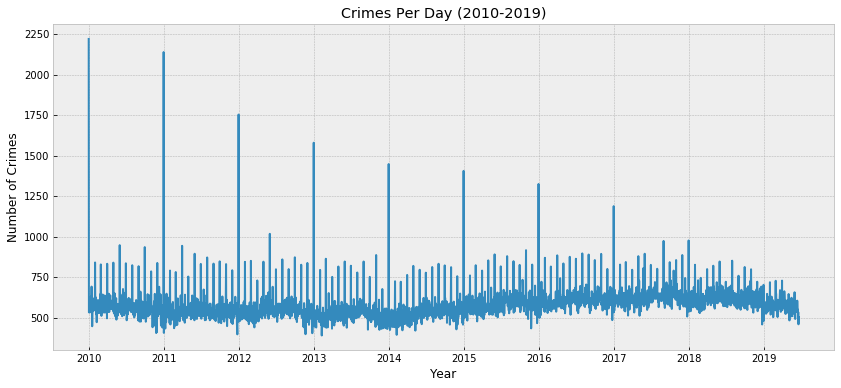

In [17]:
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time_df['crime_count'],label='Average daily tempurature')
plt.title('Crimes Per Day (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')

plt.savefig('visualizations/orig_time_data.png', bbox_inches = "tight", pad_inches=.5)

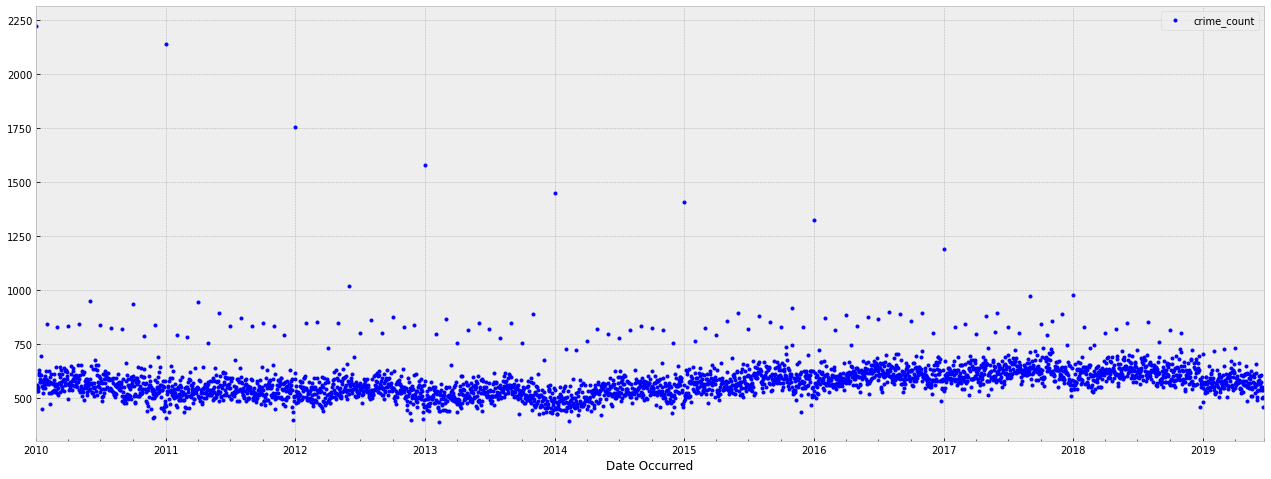

In [23]:
time_df.plot(figsize = (22,8), style = 'b.')
plt.show()

## Dickey Fuller Test

In [24]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(time_df['crime_count'])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                   -2.190871
p-value                           0.209576
# of Lags Used                   30.000000
Number of Observations Used    3429.000000
dtype: float64


we fail to reject the null because the p-value is above 0.05. this means that the original data is not stationary.

## Fixing Stationarity by Subtracting Rolling Mean

In [28]:
roll_mean = time_df.rolling(window=3).mean()
roll_std = time_df.rolling(window=3).std()

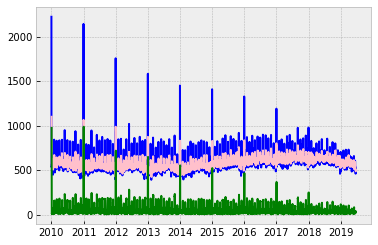

In [29]:
plt.plot(time_df['crime_count'], color = 'blue')
plt.plot(roll_mean, color = 'pink')
plt.plot(roll_std, color = 'green')

In [40]:
standardized_data = time_df - roll_mean
standardized_data.head()

,crime_count
Date Occurred,
2010-01-01,NaN
2010-01-02,NaN
2010-01-03,-559.000000
2010-01-04,14.666667
2010-01-05,-1.000000


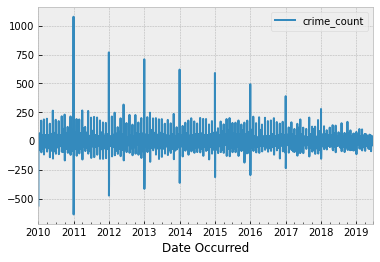

In [41]:
standardized_data.plot()

In [42]:
# fill null them with the median
standardized_data['crime_count'].fillna((standardized_data['crime_count'].median()), inplace=True)

In [43]:
standardized_data.head()

,crime_count
Date Occurred,
2010-01-01,-1.000000
2010-01-02,-1.000000
2010-01-03,-559.000000
2010-01-04,14.666667
2010-01-05,-1.000000


In [44]:
# dickey fuller test on new data
test = adfuller(standardized_data['crime_count'])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                  -23.173265
p-value                           0.000000
# of Lags Used                   30.000000
Number of Observations Used    3429.000000
dtype: float64


## Graphing ACF & PACF
This code will need to be rerun after straionarity is fixed

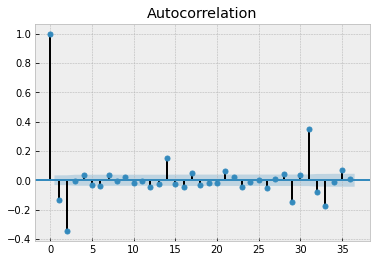

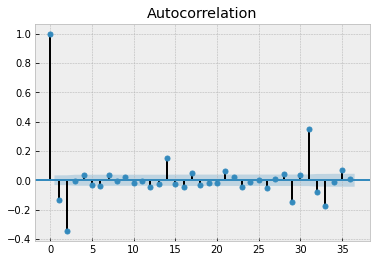

In [48]:
#plot autocorrelation for each lag (alpha is confidence interval)
plot_acf(standardized_data['crime_count'], alpha=.05)

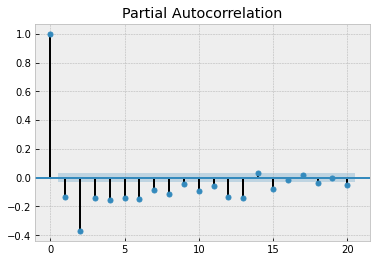

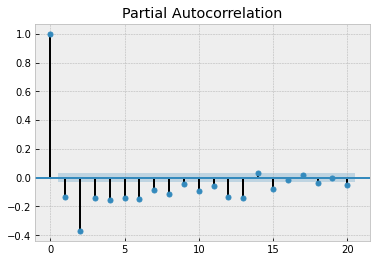

In [49]:
plot_pacf(standardized_data['crime_count'], alpha=.05, lags=20)

In [52]:
# fig, ax = plt.subplots(figsize=(16,3))
# plot_acf(standardized_data['crime_count'], alpha=.05, ax=ax)
# fig, ax = plt.subplots(figsize=(16,3))
# plot_pacf(standardized_data['crime_count'], alpha=.05, lags=20, ax=ax)

## Train-Test Split

In [62]:
# from sklearn.model_selection import TimeSeriesSplit
# tss = TimeSeriesSplit(n_splits = 3)

In [64]:
# X = time_df.drop(labels=['crime_count'], axis=1)
# y = time_df['crime_count']

In [65]:
# for train_index, test_index in tss.split(X):
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#### Trying to split df with .loc

In [14]:
# df.loc[0]

## Baseline Model: AR or ARIMA

In [3]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

# model = ARIMA(time_df[:-1], order=(1,2,1))
# model_fit = model.fit(disp=0)
# print(model_fit.summary())